In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

np.random.seed(123)

In [2]:
train = pd.read_csv("data/train_manual_features_v2.csv", index_col=0)
test = pd.read_csv("data/test_manual_features_v2.csv", index_col=0)

In [3]:
train['comment_text'] = train['comment_text'].astype(str)
test['comment_text'] = test['comment_text'].astype(str)

In [4]:
# FIXME, scaler on traning set only
def normalize(df, cols):
    for col in cols:
        print(col)
        df[col] = np.log(df[col]+0.1)
        scaler = StandardScaler()
        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
        df[col].hist()
        plt.show()
    return df

In [5]:
manual_features = ['word_count', '?_ratio', '!_ratio', '*_ratio', 'upper_ratio', 'you_ratio', 'continuous_char_ratio']

word_count


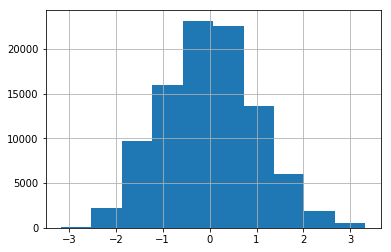

?_ratio


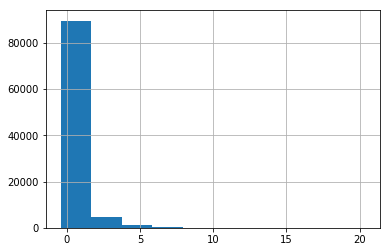

!_ratio


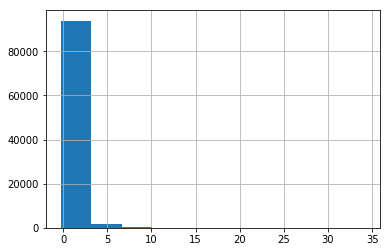

*_ratio


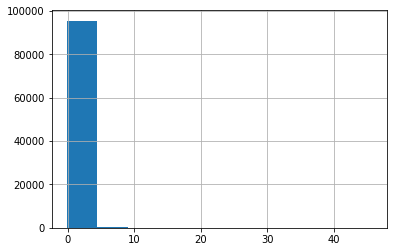

upper_ratio


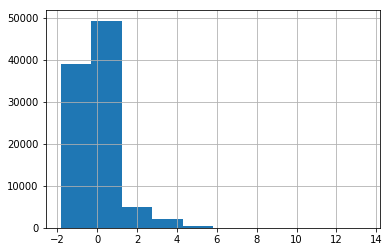

you_ratio


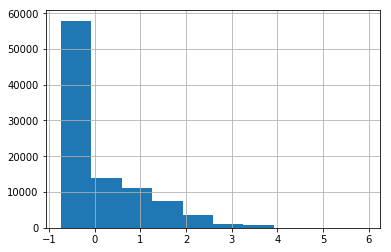

continuous_char_ratio


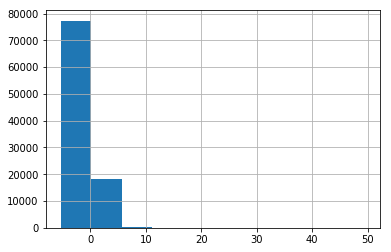

word_count


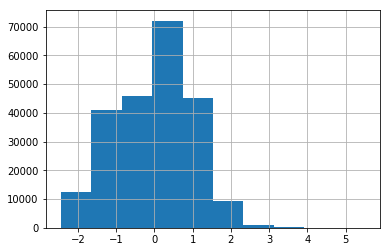

?_ratio


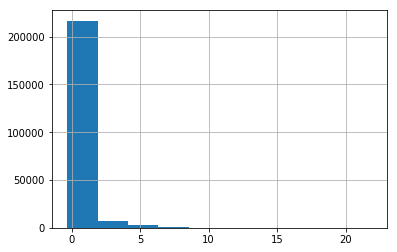

!_ratio


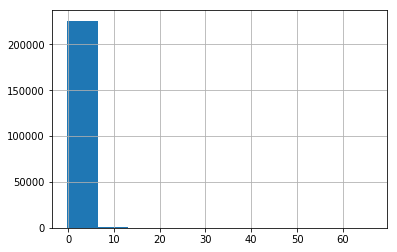

*_ratio


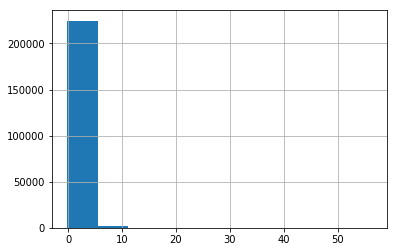

upper_ratio


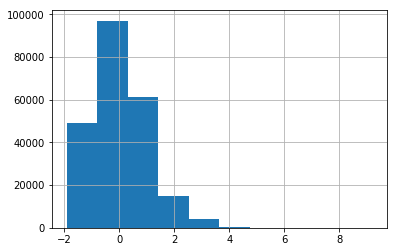

you_ratio


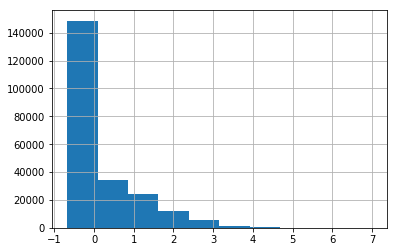

continuous_char_ratio


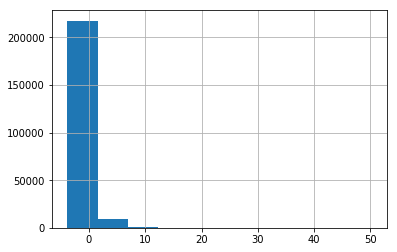

In [6]:
train = normalize(train, manual_features)
test = normalize(test, manual_features)

In [7]:
def sample1():
    train_pos = train[train["toxic"] == 1]
    train_neg = train[train["toxic"] == 0]

    print(train_pos.shape)
    print(train_neg.shape)

    train_set = train_pos.sample(frac=0.8)
    train_set = train_set.append(train_neg.sample(n=train_set.shape[0]))

    val_set = train.drop(train_set.index)

    train_set.reset_index(drop=True)
    val_set.reset_index(drop=True)

    print(train_set['toxic'].describe())
    print(val_set['toxic'].describe())
    
    return train_set, val_set, {0: 1, 1:1}

In [8]:
def sample2():
    train_set = train.sample(frac=0.8)
    val_set = train.drop(train_set.index)
    
    class_weight = {0: len(train) / 2 / (len(train) - sum(train['toxic'])), 1: len(train) / 2 / sum(train['toxic']) }
    
    train_set = train_set.reset_index(drop=True)
    val_set = val_set.reset_index(drop=True)
    
    print(train_set['toxic'].describe())
    print(val_set['toxic'].describe())
    
    return train_set, val_set, class_weight

In [9]:
train_set, val_set, class_weight = sample2()

count    76681.000000
mean         0.096386
std          0.295122
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: toxic, dtype: float64
count    19170.000000
mean         0.096296
std          0.295005
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: toxic, dtype: float64


In [10]:
from keras.preprocessing import text, sequence

max_features = 20000
maxlen = 256

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_set['comment_text'])

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
r_word_index = { v:k for k, v in tokenizer.word_index.items()}

In [12]:
X_tr = sequence.pad_sequences(tokenizer.texts_to_sequences(train_set['comment_text']), maxlen=maxlen)
X_va = sequence.pad_sequences(tokenizer.texts_to_sequences(val_set['comment_text']), maxlen=maxlen)
X_te = sequence.pad_sequences(tokenizer.texts_to_sequences(test['comment_text']), maxlen=maxlen)

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
other = ["severe_toxic", "obscene", "threat", "insult", "identity_hate"]

y_tr = train_set[list_classes]
y_va = val_set[list_classes]

In [13]:
EMBEDDING_DIM = 300

from tqdm import tqdm

embeddings_index = {}
f = open("data/glove.6B.300d.txt".format(EMBEDDING_DIM))
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:29, 13523.13it/s]

Found 400000 word vectors.


In [14]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, Flatten, Activation
from keras.layers import Average, Lambda, RepeatVector, LSTM, Bidirectional, GlobalMaxPool1D, Dropout, GRU, Conv1D, Reshape, MaxPooling1D, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.constraints import non_neg, unit_norm

DROPOUT=0.1

def mixing_layer(pred, emb):
    x = RepeatVector(len(list_classes))(pred)
    x = Lambda(lambda x: x * (np.ones([len(list_classes), len(list_classes)]) - np.eye(len(list_classes))))(x)
    c = Concatenate()([emb, x])
    return c


def split_dense(emb_layer, activation):
    k = []
    for i in range(len(list_classes)):
        k.append(Lambda(lambda x: x[:,i,:])(emb_layer))
    k = [Dense(1, activation=activation)(s) for s in k]
    return Concatenate()(k)    


def get_model_mix_layer():
    embed_size = len(list_classes) * 64
    inp = Input(shape=(maxlen, ))
    mf_inp = Input(shape=(len(manual_features), ))
    r_mf_inp = RepeatVector(len(list_classes))(mf_inp)
    
    x = Embedding(max_features, embed_size)(inp)
    x = GlobalMaxPool1D()(x)
    x = Reshape([len(list_classes), -1])(x)
    emb = Concatenate()([x, r_mf_inp])
    
    emb = Dropout(DROPOUT)(emb)
    
    pred = split_dense(emb, 'selu')
    mix = mixing_layer(pred, emb)
    final = split_dense(mix, 'sigmoid')

    #final = Concatenate()([pred, final])    
    #final = Reshape([-1, 2])(final)
    #final = Dense(1, activation='sigmoid')(final)
    #final = Flatten()(final)

    model = Model(inputs=[inp, mf_inp], outputs=final)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', 'binary_crossentropy'])

    return model

model = get_model_mix_layer()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 256)          0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 256, 384)     7680000     input_45[0][0]                   
__________________________________________________________________________________________________
global_max_pooling1d_23 (Global (None, 384)          0           embedding_23[0][0]               
__________________________________________________________________________________________________
input_46 (InputLayer)           (None, 7)            0                                            
__________________________________________________________________________________________________
reshape_36

In [ ]:
batch_size = 32
epochs = 2000

file_path="weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', save_best_only=True)
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
callbacks_list = [checkpoint, early] #early
model.fit(
    [X_tr, train_set[manual_features]],
    y_tr, 
    class_weight=None, 
    validation_data=([X_va, val_set[manual_features]], y_va), 
    shuffle=True, 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks_list
)

Train on 76681 samples, validate on 19170 samples
Epoch 1/2000
76681/76681 [==============================] - 136s 2ms/step - loss: 0.1009 - acc: 0.9699 - binary_crossentropy: 0.1009 - val_loss: 0.0535 - val_acc: 0.9814 - val_binary_crossentropy: 0.0535
Epoch 2/2000
76681/76681 [==============================] - 134s 2ms/step - loss: 0.0473 - acc: 0.9830 - binary_crossentropy: 0.0473 - val_loss: 0.0481 - val_acc: 0.9823 - val_binary_crossentropy: 0.0481
Epoch 3/2000
76681/76681 [==============================] - 134s 2ms/step - loss: 0.0388 - acc: 0.9856 - binary_crossentropy: 0.0388 - val_loss: 0.0475 - val_acc: 0.9826 - val_binary_crossentropy: 0.0475
Epoch 4/2000
76681/76681 [==============================] - 133s 2ms/step - loss: 0.0328 - acc: 0.9873 - binary_crossentropy: 0.0328 - val_loss: 0.0485 - val_acc: 0.9824 - val_binary_crossentropy: 0.0485
Epoch 5/2000
76681/76681 [==============================] - 133s 2ms/step - loss: 0.0281 - acc: 0.9893 - binary_crossentropy: 0.0281 -

In [ ]:
model.load_weights(file_path)


pred = model.predict(X_va, batch_size=128)
int_pred = pred >= 0.5

In [ ]:
from sklearn import metrics

for i, c in enumerate(list_classes):
    print(c)
    print("roc:\t\t%.3f" % metrics.roc_auc_score(val_set[c], pred[:,i]))
    print("f1:\t\t%.3f" % metrics.f1_score(val_set[c], int_pred[:,i]))
    print("precision:\t%.3f" % metrics.precision_score(val_set[c], int_pred[:,i]))
    print("recall:\t\t%.3f" %metrics.recall_score(val_set[c], int_pred[:,i]))
    print("log loss:\t%.3f" %metrics.log_loss(val_set[c], pred[:,i]))

    m = metrics.confusion_matrix(val_set[c], int_pred[:,i])
    tp = m[1,1]
    fp = m[0,1]
    tn = m[0,0]
    fn = m[1,0]
    print("tp:\t\t%d"%tp)
    print("fp:\t\t%d"%fp)
    print("tn:\t\t%d"%tn)
    print("fn:\t\t%d"%fn)
    
    print("tpr:\t\t%.3f"%(tp / (tp+fn)))
    print("fpr:\t\t%.3f"%(fp / (fp+tn)))

    
    precision, recall, threshold = metrics.precision_recall_curve(val_set[c], pred[:,i])
    plt.figure(0)
    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
         color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve:')
    plt.show()
    
    fpr, tpr, _ = metrics.roc_curve(val_set[c], pred[:,i])
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [ ]:
for i, row in val_set[(pred[:, 0] <= 0.1) & (val_set['toxic'] == 1)].sample(1).iterrows():
    print(row['comment_text'])
    print(row)

In [ ]:
model.load_weights(file_path)
sample_submission = pd.read_csv("./data/sample_submission.csv")

sample_submission[list_classes] = y_test

sample_submission.to_csv("baseline.csv", index=False)

In [ ]:
model.load_weights(file_path)

y_test = model.predict([X_te, test[manual_features]], batch_size=2048)

sample_submission = pd.read_csv("./data/sample_submission.csv")
sample_submission[list_classes] = y_test
sample_submission.to_csv("baseline.csv", index=False)

In [ ]:
tokenizer.word_counts['pagan']
tokenizer.word_counts